TASK-4

Objective: To analyze and visualize sentiment patterns in social media data to understand public opinion and attitudes towards specific topics or brands.

Loading Libraries

In [25]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import re

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

Dataset

In [26]:
train_data = pd.read_csv('/content/drive/MyDrive/twitter_training.csv')
validation_data = pd.read_csv('/content/drive/MyDrive/twitter_validation.csv')
train_head = train_data.head()
validation_head = validation_data.head()

print(train_head)
print(validation_head)

   2401  Borderlands  Positive  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

  im getting on borderlands and i will murder you all ,  
0  I am coming to the borders and I will kill you...     
1  im getting on borderlands and i will kill you ...     
2  im coming on borderlands and i will murder you...     
3  im getting on borderlands 2 and i will murder ...     
4  im getting into borderlands and i can murder y...     
   3364   Facebook Irrelevant  \
0   352     Amazon    Neutral   
1  8312  Microsoft   Negative   
2  4371      CS-GO   Negative   
3  4433     Google    Neutral   
4  6273       FIFA   Negative   

  I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣  
0

Checking for missing values and duplicates

In [27]:
missing_train = train_data.isnull().sum()
missing_validation = validation_data.isnull().sum()

duplicates_train = train_data.duplicated().sum()
duplicates_validation = validation_data.duplicated().sum()

print(missing_train)
print(missing_validation)
print(duplicates_train)
print(duplicates_validation)

2401                                                       0
Borderlands                                                0
Positive                                                   0
im getting on borderlands and i will murder you all ,    686
dtype: int64
3364                                                                                                                                                                                                                                                  0
Facebook                                                                                                                                                                                                                                              0
Irrelevant                                                                                                                                                                                                                                            0

Unique values

In [28]:
train_sentiment_distribution = train_data.iloc[:, 2].value_counts()
validation_sentiment_distribution = validation_data.iloc[:, 2].value_counts()


unique_entities_train = train_data.iloc[:, 1].nunique()

print(train_sentiment_distribution)
print(validation_sentiment_distribution)
print(unique_entities_train)

Negative      22542
Positive      20831
Neutral       18318
Irrelevant    12990
Name: Positive, dtype: int64
Neutral       285
Positive      277
Negative      266
Irrelevant    171
Name: Irrelevant, dtype: int64
32


In [29]:
train_data.info()
validation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 4 columns):
 #   Column                                                                                                                                                                                                                                     

Removing duplicate rows

In [30]:
train_data_cleaned = train_data.drop_duplicates()
train_data_cleaned = train_data_cleaned.dropna(subset=[train_data.columns[3]])

remaining_duplicates_train = train_data_cleaned.duplicated().sum()
remaining_missing_train = train_data_cleaned.isnull().sum()

remaining_duplicates_train
remaining_missing_train

2401                                                     0
Borderlands                                              0
Positive                                                 0
im getting on borderlands and i will murder you all ,    0
dtype: int64

Graphical Analysis

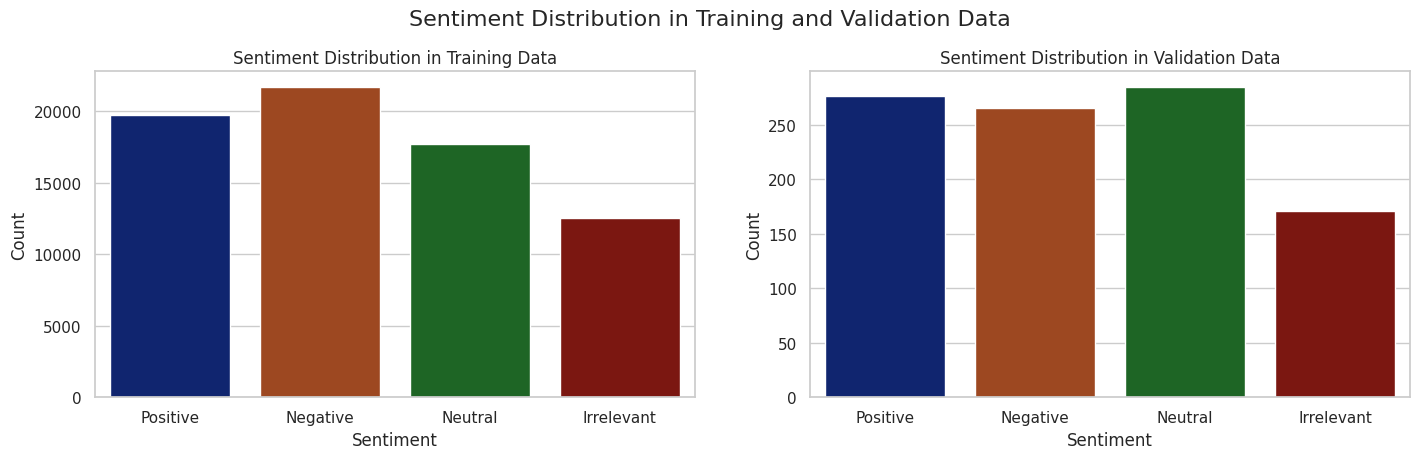

In [31]:
colors = sns.color_palette("dark")

fig, ax = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})

sns.countplot(data=train_data_cleaned, x=train_data_cleaned.columns[2],
              order=['Positive', 'Negative', 'Neutral', 'Irrelevant'],
              palette=colors, ax=ax[0])
ax[0].set_title('Sentiment Distribution in Training Data')
ax[0].set_ylabel('Count')
ax[0].set_xlabel('Sentiment')

sns.countplot(data=validation_data, x=validation_data.columns[2],
              order=['Positive', 'Negative', 'Neutral', 'Irrelevant'],
              palette=colors, ax=ax[1])
ax[1].set_title('Sentiment Distribution in Validation Data')
ax[1].set_ylabel('Count')
ax[1].set_xlabel('Sentiment')

plt.tight_layout(pad=3)

plt.suptitle('Sentiment Distribution in Training and Validation Data', fontsize=16)
plt.show()

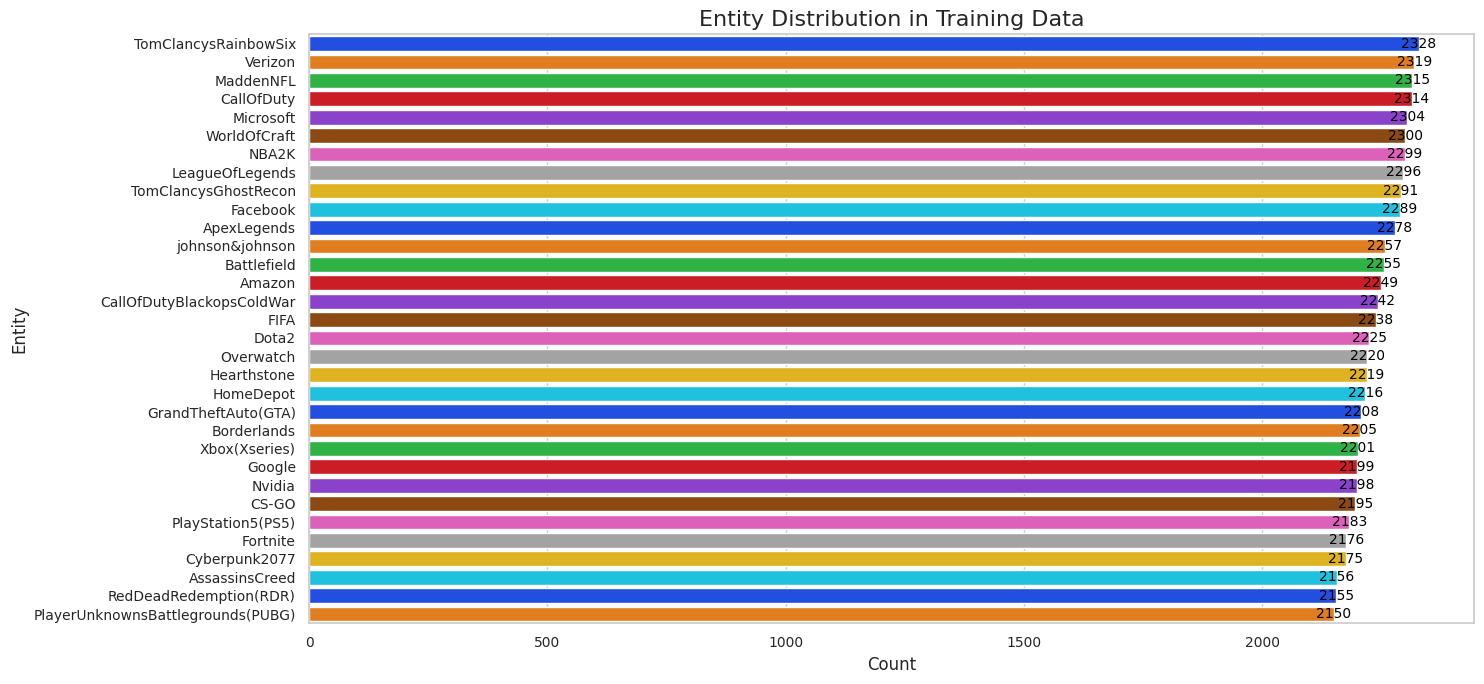

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a custom color palette with four distinct colors
custom_palette = sns.color_palette("bright")

plt.figure(figsize=(15, 7))

# Plot entity distribution for training data
sns.countplot(data=train_data_cleaned, y=train_data_cleaned.columns[1],
              order=train_data_cleaned[train_data_cleaned.columns[1]].value_counts().index,
              palette=custom_palette)

plt.title('Entity Distribution in Training Data', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Entity', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add count annotations on the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_width())}',
                       (p.get_width() + 0.1, p.get_y() + p.get_height() / 2),
                       ha='center', va='center', fontsize=10, color='black')

plt.tight_layout()
plt.show()

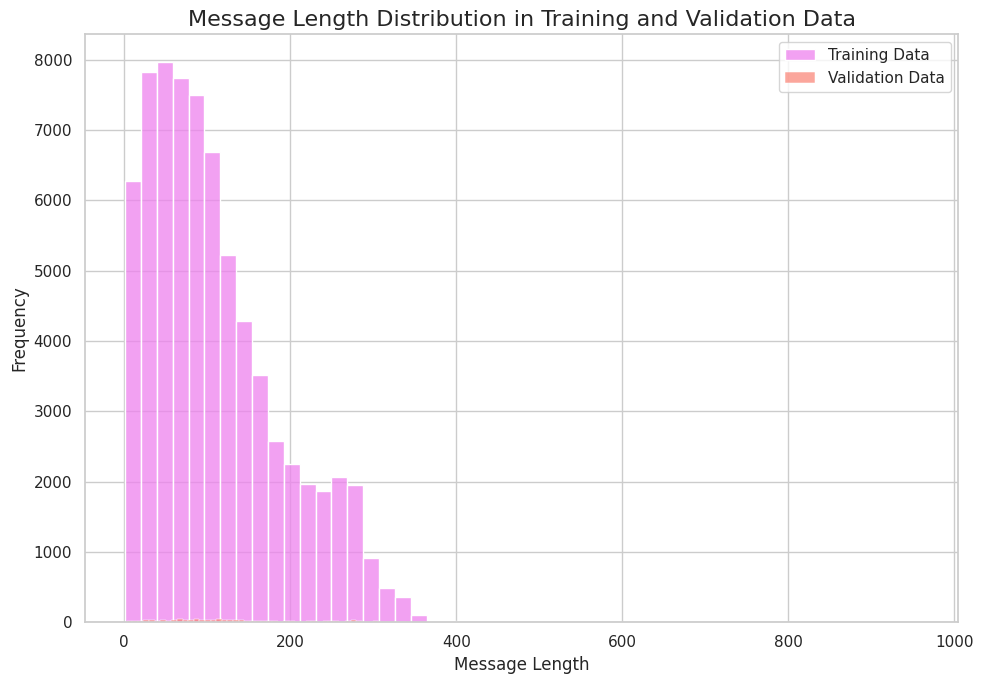

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the length of each message
train_data_cleaned['message_length'] = train_data_cleaned[train_data_cleaned.columns[3]].apply(len)
validation_data['message_length'] = validation_data[validation_data.columns[3]].apply(len)

# Set up the plot
plt.figure(figsize=(10, 7))

# Plot message length distribution for training data
sns.histplot(train_data_cleaned['message_length'], bins=50, color='violet', label='Training Data')

# Plot message length distribution for validation data on top of the first plot
sns.histplot(validation_data['message_length'], bins=50, color='salmon', label='Validation Data', alpha=0.7)

plt.title('Message Length Distribution in Training and Validation Data', fontsize=16)
plt.xlabel('Message Length', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()

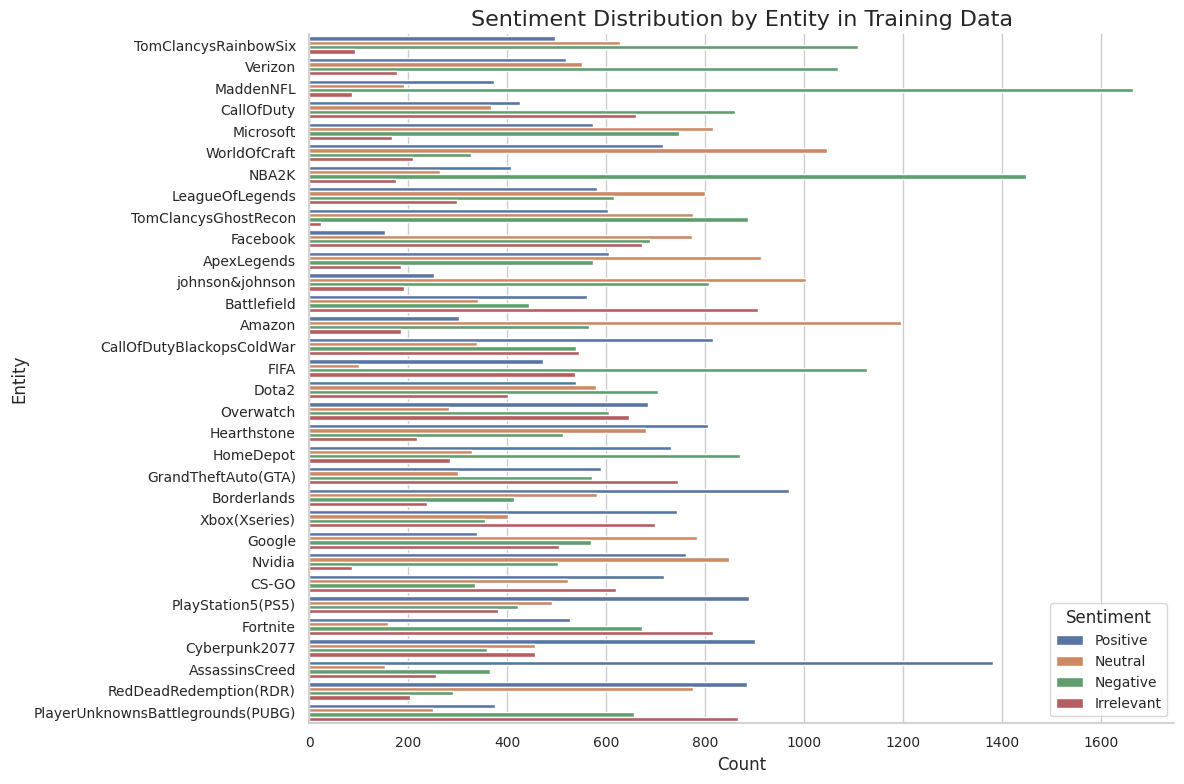

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style to whitegrid
sns.set(style="whitegrid")

# Set up the plot
plt.figure(figsize=(12, 8))

# Basic count plot
sns.countplot(data=train_data_cleaned, y=train_data_cleaned.columns[1],
              hue=train_data_cleaned.columns[2],
              order=train_data_cleaned[train_data_cleaned.columns[1]].value_counts().index,
              palette="deep")

plt.title('Sentiment Distribution by Entity in Training Data', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Entity', fontsize=12)
plt.legend(title='Sentiment', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove top and right spines for cleaner look
sns.despine()

plt.tight_layout()
plt.show()


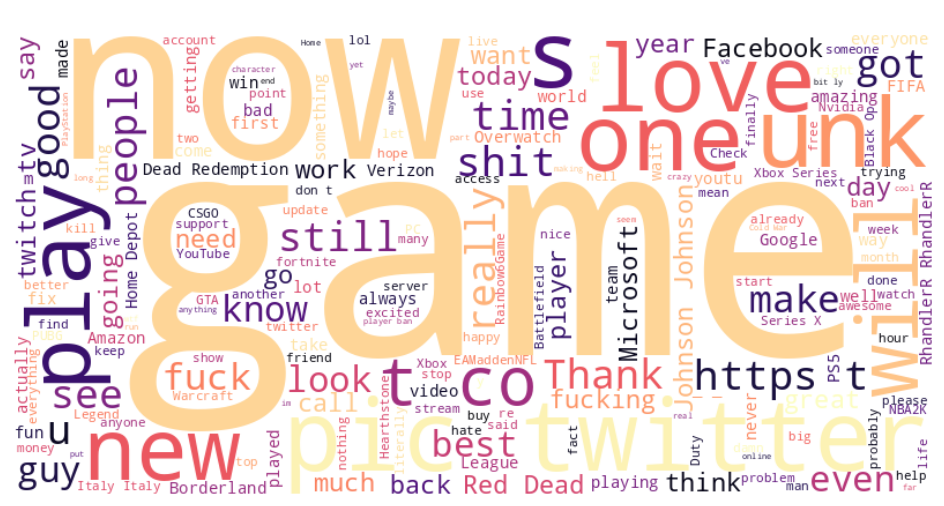

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the word cloud for the entire training dataset
all_text = " ".join(tweet for tweet in train_data_cleaned[train_data_cleaned.columns[3]])

# Define a custom color scheme for dark theme
color_map_dark = plt.cm.magma_r

# Generate the WordCloud with custom parameters for dark theme
wordcloud_all_dark = WordCloud(
    background_color='white',
    width=800,
    height=400,
    max_words=200,
    colormap=color_map_dark,
    contour_color='white',
    contour_width=1,
    random_state=42
).generate(all_text)

# Plot the Word Cloud with a dark theme
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_all_dark, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for All Tweets in Training Data (Dark Theme)', fontsize=16, color='white')
plt.show()

In [ ]:
# Initialize sentiment categories
sentiments = ['Positive', 'Negative', 'Neutral', 'Irrelevant']

# Set up the plots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Generate and plot word clouds for each sentiment
for sentiment, ax in zip(sentiments, axs.ravel()):
    sentiment_text = " ".join(tweet for tweet in train_data_cleaned[train_data_cleaned[train_data_cleaned.columns[2]] == sentiment][train_data_cleaned.columns[3]])
    wordcloud_sentiment = WordCloud(background_color='pink', width=400, height=200).generate(sentiment_text)

    ax.imshow(wordcloud_sentiment, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(f'Word Cloud for {sentiment} Sentiment')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Alternative function to preprocess text without lemmatization or NLTK stopwords
def preprocess_text_simplified(text):
    # Convert to lowercase
    text = text.lower()
    # Simple tokenization using split (without relying on NLTK)
    tokens = text.split()
    # Remove special characters and numbers
    tokens = [token for token in tokens if token.isalpha()]
    return " ".join(tokens)

# Apply simplified preprocessing to training data
train_data_cleaned['processed_message_simplified'] = train_data_cleaned[train_data_cleaned.columns[3]].apply(preprocess_text_simplified)

# Extract most frequent terms using CountVectorizer with simplified preprocessing
vectorizer_simplified = CountVectorizer(max_features=20)
X_simplified = vectorizer_simplified.fit_transform(train_data_cleaned['processed_message_simplified'])
frequent_terms_simplified = vectorizer_simplified.get_feature_names_out()

frequent_terms_simplified


In [ ]:
# Adjusting the labels: Convert "Irrelevant" labels to "Neutral"
train_data_cleaned[train_data_cleaned.columns[2]] = train_data_cleaned[train_data_cleaned.columns[2]].replace('Irrelevant', 'Neutral')
validation_data[validation_data.columns[2]] = validation_data[validation_data.columns[2]].replace('Irrelevant', 'Neutral')

# Check the updated sentiment distribution in the training and validation data
updated_train_sentiment_distribution = train_data_cleaned[train_data_cleaned.columns[2]].value_counts()
updated_validation_sentiment_distribution = validation_data[validation_data.columns[2]].value_counts()

updated_train_sentiment_distribution, updated_validation_sentiment_distribution

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 features for computational efficiency

# Fit and transform the preprocessed text from the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(train_data_cleaned['processed_message_simplified'])

# Apply simplified preprocessing to the validation data
validation_data['processed_message_simplified'] = validation_data[validation_data.columns[3]].apply(preprocess_text_simplified)

# Transform the preprocessed text from the validation data
X_validation_tfidf = tfidf_vectorizer.transform(validation_data['processed_message_simplified'])

# Extract target labels for training and validation
y_train = train_data_cleaned[train_data_cleaned.columns[2]]
y_validation = validation_data[validation_data.columns[2]]

X_train_tfidf.shape, X_validation_tfidf.shape


In [ ]:
# Extract text for Positive sentiment from the training dataset
positive_text = " ".join(tweet for tweet in train_data_cleaned[train_data_cleaned[train_data_cleaned.columns[2]] == 'Positive']['processed_message_simplified'])

# Generate word cloud for Positive sentiment
wordcloud_positive = WordCloud(background_color='violet', width=800, height=400).generate(positive_text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment in Training Data')
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# Define the target variable for training and validation again
y_train = train_data_cleaned[train_data_cleaned.columns[2]]
y_validation = validation_data[validation_data.columns[2]]

# Create the ML pipeline with TF-IDF vectorization and Logistic Regression
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('classifier', LogisticRegression(solver='sag', multi_class='auto', max_iter=10000))  # using 'sag' solver for faster convergence
])

# Train the pipeline model using the training data
pipeline.fit(train_data_cleaned['processed_message_simplified'], y_train)

# Validate the model's performance on the validation dataset
validation_accuracy = pipeline.score(validation_data['processed_message_simplified'], y_validation)

validation_accuracy

We have done sentiment analysis of twitter data set and validated our model with 0.8 accuracy.